In [13]:
from imports import *
from defs import numberop, Sigma_minus, Sigma_plus, Sigma_x, Sigma_y, Sigma_z
from exactDiagMethods import Liouvillian, perform_exact_diag, build_exact_diag_hamiltonian, Enlarge_Matrix_site_j,output_exact_diag_results, Correlation_Matrix_i_Matrix_j, generate_random_state
from globalMethods import verify_density_matrix, build_initial_states, output_results
from vqteMethods import hamiltonian_generation_simple, hamiltonian_generation, perform_vqte

In [14]:

def main():
    # Initialize the simulation parameters
    N = 2
    gamma=0.05
    eps=1
    mu_L=2
    mu_R=0.1
    T_L = 50
    T_R= 10
    beta_L=1/T_L
    beta_R=1/T_R
    F_L = 1/(np.exp(beta_L*(eps-mu_L))+1)
    F_R = 1/(np.exp(beta_R*(eps-mu_R))+1)

    time = 300.0
    dt = 0.1
    nt = int(time/dt)
    exact_diag_ham= build_exact_diag_hamiltonian(N, eps)


    exact_diag_init_state = generate_random_state(N)
    print(exact_diag_init_state)
    #ham_real, ham_imag = hamiltonian_generation(eps, gamma, F_L, F_R)

    #vqte_init_state, exact_diag_init_state, ansatz, init_param_values = build_initial_states(ham_real)

    # exact_diag_ham = build_exact_diag_hamiltonian(N,delta_list, J_list)

    # print(vqte_init_state)
    # print(exact_diag_init_state)

    # # Perform exact diagonalization
    exact_diag_results, time_points, steadyState = perform_exact_diag(gamma, F_L, F_R, dt, nt, exact_diag_init_state,exact_diag_ham,N, eps)

    # # Perform VQTE simulation
    # vqte_results, trace_list = perform_vqte(ham_real, ham_imag, vqte_init_state, dt, nt, ansatz, init_param_values)
    # #Example VQE
    # # Output results
    output_exact_diag_results(exact_diag_results, time, nt, eps, mu_L,mu_R,T_L, T_R, time_points, steadyState)
    # output_results(vqte_results, exact_diag_results, time, nt, time_points, trace_list, steadyState)

[[ 0.11812392+0.j         -0.07085326-0.11326512j -0.04054149-0.02624247j
   0.12137979+0.0153815j ]
 [-0.07085326+0.11326512j  0.31635443+0.j         -0.13045297-0.00896634j
  -0.05403385+0.1237947j ]
 [-0.04054149+0.02624247j -0.13045297+0.00896634j  0.42378019+0.j
  -0.09132731-0.01298279j]
 [ 0.12137979-0.0153815j  -0.05403385-0.1237947j  -0.09132731+0.01298279j
   0.14174147+0.j        ]]
Reference number operator expectation value: (1.0174849914518005-4.1832612641416387e-16j)
Is Hermitian: True
Trace: (1+0j) (should be 1)
Eigenvalues: [0.00215521 0.04259282 0.39501642 0.56023555]
All eigenvalues ≥ 0: True
Purity (Tr(ρ²)): (0.47172063705683026+0j) (should be 1 for pure state)
Initial expectation value of number operator: [np.float64(0.5655216543118302)]


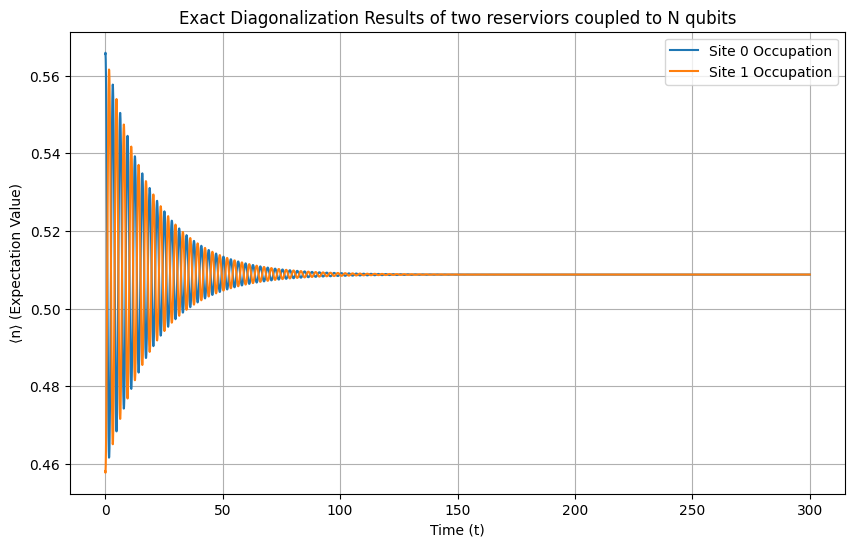

In [15]:
main()